In [4]:
import math
import keras
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
import tensorflow.keras.optimizers as op
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

In [83]:
batchsize = 16

train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
training_set = train_gen.flow_from_directory(
    directory="C:/Users/DEVA/Dropbox/My PC (NANI)/Downloads/Fake_note_Recognition/dataset/training_set",
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)



Found 6000 images belonging to 2 classes.


In [74]:
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_set = test_gen.flow_from_directory(
    directory="C:/Users/DEVA/Dropbox/My PC (NANI)/Downloads/Fake_note_Recognition/dataset/test_set",
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 3000 images belonging to 2 classes.


In [75]:
#imports the mobilenet model and discards the last fully connected neuron layer.
mobilenetmodel = MobileNetV2(weights='imagenet', input_shape= (224, 224, 3), include_top=False)
print(mobilenetmodel.summary())

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [76]:
x = mobilenetmodel.output
x = GlobalAveragePooling2D()(x)
preds = Dense(2, activation='softmax', kernel_regularizer=regularizers.l2(0.001))(x) # final layer with softmax activation

In [77]:
model_final = Model(inputs = mobilenetmodel.input, outputs = preds)

In [78]:
training_size = 6000
validation_size = 3000
steps_per_epoch = math.ceil(training_size / batch_size)
validation_steps = math.ceil(validation_size / batch_size)

In [79]:
# compilation 1
optimizer1 = op.SGD(lr=0.001)
model_final.compile(optimizer = optimizer1, loss='binary_crossentropy',metrics=['accuracy'])
print("total layer count", len(model_final.layers))

total layer count 156


In [80]:
print(model_final.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [81]:
earlystop1 = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_13[0][0]                   
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

C:\Users\DEVA\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.


mobilenet_watermark_class_indices {'no_watermark': 0, 'yes_watermark': 1}


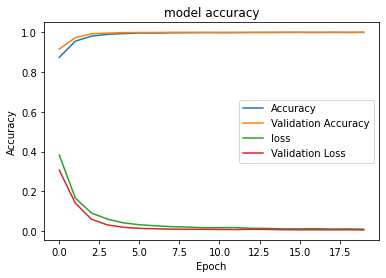

In [118]:
hist1 = model_final.fit_generator(training_set, validation_data=test_set, epochs=20,callbacks=[earlystop1],workers=10,shuffle=True)

model_final.save("watermark_mobilenetmodel.h5")

print("mobilenet_watermark_class_indices", training_set.class_indices)
f = open("mobilenet_watermark_class_indices.txt", "w")
f.write(str(training_set.class_indices))
f.close()

plt.plot(hist1.history["accuracy"])
plt.plot(hist1.history['val_accuracy'])
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.savefig('mobilenet' + '_plot.png')
plt.show()

In [2]:
from tensorflow.keras.models import load_model
import ast

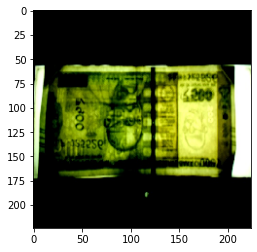

1/1 [==============================] - 1s 799ms/step
yes_watermark: 100.0%
no_watermark: 1.1389118093063644e-06%
Final Result:  {'yes_watermark': 100.0}


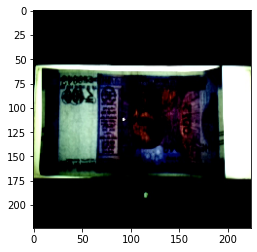

1/1 [==============================] - 0s 39ms/step
no_watermark: 100.0%
yes_watermark: 2.92712576399623e-08%
Final Result:  {'no_watermark': 100.0}


In [5]:
model = load_model('watermark_mobilenetmodel.h5')
f = open("mobilenet_watermark_class_indices.txt", "r")
labels = f.read()
labels = ast.literal_eval(labels)
final_labels = {v: k for k, v in labels.items()}


def predict_image(imgname, from_test_dir):
    test_image = image.load_img(imgname, target_size = (224, 224))

    plt.imshow(test_image)
    plt.show()

    test_image = np.asarray(test_image)
    test_image = np.expand_dims(test_image, axis=0)
    test_image = (2.0 / 255.0) * test_image - 1.0
    result = model.predict(test_image)

    result_dict = dict()
    for key in list(final_labels.keys()):
        result_dict[final_labels[key]] = result[0][key]
    sorted_results = {k: v for k, v in sorted(result_dict.items(), key=lambda item: item[1], reverse=True)}

    if not from_test_dir:
        print('=' * 50)
        for label in sorted_results.keys():
            print("{}: {}%".format(label, sorted_results[label] * 100))

    final_result = dict()
    final_result[list(sorted_results.keys())[0]] = sorted_results[list(sorted_results.keys())[0]] * 100

    return final_result

def verify_test_dir():
    path = '..\\batch-test-images'
    folders = os.listdir(path)

    correct_preds = 0
    file_count = 0
    for fold in folders:
        files = os.listdir(path + '\\' + fold)
        for filename in files:
            final_string = fold
            prediction = predict_image(path + '\\{}\\'.format(fold) + filename, True)
            if list(prediction.keys())[0] == final_string:
                print("{}\{}: Correct Prediction".format(fold, filename), prediction)
                correct_preds += 1
            else:
                print("{}\{}: INCORRECT PREDICTION".format(fold, filename), prediction)
            file_count += 1

    print(correct_preds, file_count)


print('=' * 50)
final_result1 = predict_image('..\\test-images\\yesww.jpg', False)
print("Final Result: ", final_result1)
final_result2 = predict_image('..\\test-images\\now.jpg', False)
print("Final Result: ", final_result2)
# verify_test_dir()
